In [1]:
%pylab inline

import rpeakdetectmod
import rpeakdetect
import pandas as pd
import numpy as np
import scipy.signal as scs

Populating the interactive namespace from numpy and matplotlib


### using BIOSTREAM

In [18]:
data = pd.read_csv("/Users/user/Downloads/sbj038 (EXP)/2016-11-22-(11-45-39)-biostream.txt")

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242417 entries, 0 to 242416
Data columns (total 5 columns):
Date           242417 non-null object
Time           242417 non-null object
Seconds        242417 non-null float64
ECG            242417 non-null float64
Respiration    242417 non-null float64
dtypes: float64(3), object(2)
memory usage: 11.1+ MB


In [20]:
data.head()

,Date,Time,Seconds,ECG,Respiration
0,2016/11/22,11:45:39.052,0.000,0.130005,4.595337
1,2016/11/22,11:45:39.052,0.005,0.119934,4.595337
2,2016/11/22,11:45:39.052,0.010,0.106506,4.595947
3,2016/11/22,11:45:39.052,0.015,0.087891,4.595947
4,2016/11/22,11:45:39.052,0.020,0.072327,4.595337


In [21]:
signal = data["ECG"]

In [22]:
len(signal)/200.

1212.085

In [23]:
10*200

2000

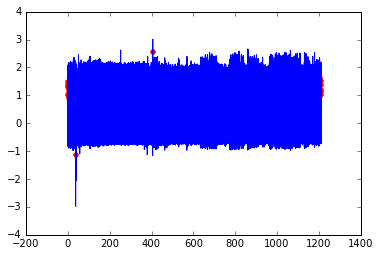

In [25]:
rpeakdetect.plot_peak_detection(signal, 200)

In [26]:
rpeaks = rpeakdetect.detect_beats(signal, 200)
len(rpeaks)

1510

In [27]:
rpeaks

array([   114,    282,    456, ..., 241893, 242074, 242268])

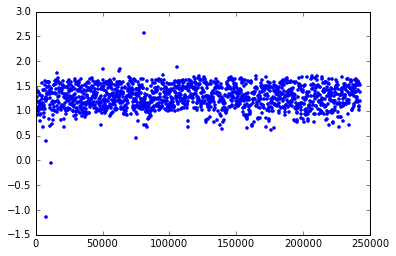

In [28]:
plt.plot(signal[rpeaks], '.')

In [29]:
rpeaks

array([   114,    282,    456, ..., 241893, 242074, 242268])

In [30]:
def get_RR(data, f=200):
    
    rpeaks = rpeakdetect.detect_beats(data["ECG"],f)
    RR = np.array([data["Seconds"][rpeaks[i+1]]-data["Seconds"][rpeaks[i]] for i in range(len(rpeaks)-1)]).astype(float)
    return RR

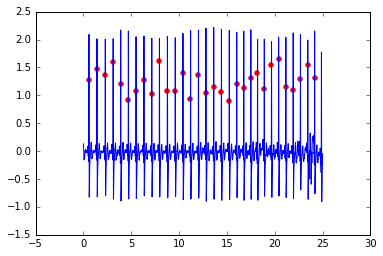

In [31]:
rpeakdetect.plot_peak_detection(signal[:5000], 200)

In [32]:
RR = get_RR(data, 200)

In [33]:
pd.Series(RR).describe()

count    1509.000000
mean        0.802555
std         0.108255
min         0.550000
25%         0.730000
50%         0.785000
75%         0.860000
max         1.570000
dtype: float64

### rpeakdetect disintegration

In [34]:
sample1 = signal[:5000]
sample2 = signal[5000:10000]

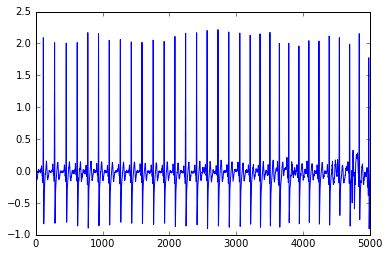

In [35]:
plt.plot(sample1)

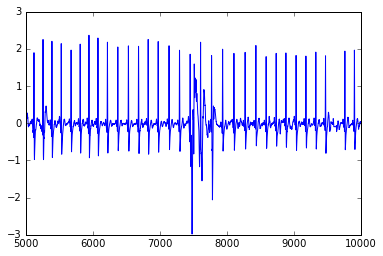

In [36]:
plt.plot(sample2)

In [37]:
#modified

import sys
import numpy as np
import scipy.signal
import scipy.ndimage

def detect_beats(
		ecg,	# The raw ECG signal
		rate,	# Sampling rate in HZ
		# Window size in seconds to use for 
		ransac_window_size=5.0,
		# Low frequency of the band pass filter
		lowfreq=5.0,
		# High frequency of the band pass filter
		highfreq=15.0,
		):
	"""
	ECG heart beat detection based on
	http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
	with some tweaks (mainly robust estimation of the rectified signal
	cutoff threshold).
	"""

	ransac_window_size = int(ransac_window_size*rate)

	lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
	highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
	# TODO: Could use an actual bandpass filter
	ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
	ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
	
	# Square (=signal power) of the first difference of the signal
	decg = np.diff(ecg_band)
	decg_power = decg**2
	
	# Robust threshold and normalizator estimation
	thresholds = []
	max_powers = []
	for i in range(len(decg_power)/ransac_window_size):
		sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
		d = decg_power[sample]
		thresholds.append(0.5*np.std(d))
		max_powers.append(np.max(d))

	threshold = 0.5*np.std(decg_power)
	threshold = np.median(thresholds)
	max_power = np.median(max_powers)
	decg_power[decg_power < threshold] = 0

	decg_power /= max_power
	decg_power[decg_power > 1.0] = 1.0
	square_decg_power = decg_power**2

	shannon_energy = -square_decg_power*np.log(square_decg_power)
	shannon_energy[~np.isfinite(shannon_energy)] = 0.0

	mean_window_len = int(rate*0.125+1)
	lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
	#lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
	
	lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
	lp_energy_diff = np.diff(lp_energy)

	zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
	zero_crossings = np.flatnonzero(zero_crossings)
	zero_crossings -= 1
	return zero_crossings

def plot_peak_detection(ecg, rate, rws=5.0, lf=5.0, hf=15.0):
	import matplotlib.pyplot as plt
	dt = 1.0/rate
	t = np.linspace(0, len(ecg)*dt, len(ecg))
	plt.plot(t, ecg)

	peak_i = detect_beats(ecg, rate, rws, lf, hf)
	plt.scatter(t[peak_i], ecg[peak_i], color='red')
	plt.show()

""" 
if __name__ == '__main__':
    
	#rate = float(sys.argv[1])
	print sys.argv[1]
	ecg = np.loadtxt(sys.stdin)
	if len(sys.argv) > 2 and sys.argv[2] == 'plot':
		plot_peak_detection(ecg, rate)
	else:	
		peaks = detect_beats(ecg, rate)
		sys.stdout.write("\n".join(map(str, peaks)))
	sys.stdout.write("\n")
"""

' \nif __name__ == \'__main__\':\n    \n\t#rate = float(sys.argv[1])\n\tprint sys.argv[1]\n\tecg = np.loadtxt(sys.stdin)\n\tif len(sys.argv) > 2 and sys.argv[2] == \'plot\':\n\t\tplot_peak_detection(ecg, rate)\n\telse:\t\n\t\tpeaks = detect_beats(ecg, rate)\n\t\tsys.stdout.write("\n".join(map(str, peaks)))\n\tsys.stdout.write("\n")\n'

In [38]:
peaks = detect_beats(sample1, 200)

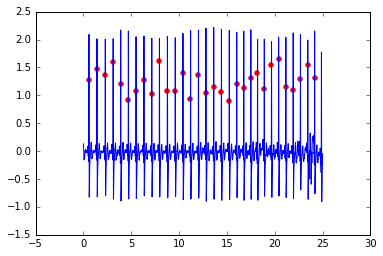

In [39]:
plot_peak_detection(sample1, 200)

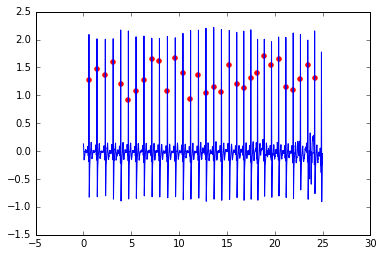

In [40]:
#Experiment values here
plot_peak_detection(sample1, 200, 1.0, .1250)

In [41]:
def true_peaks(signal, peaks, r=10):
    tp = [np.argmax(signal[p-r:p+r]) for p in peaks]
    return np.array(tp)

In [42]:
peaks

array([ 114,  282,  456,  620,  778,  938, 1098, 1264, 1427, 1588, 1754,
       1918, 2079, 2238, 2403, 2559, 2722, 2883, 3047, 3203, 3350, 3498,
       3639, 3779, 3931, 4080, 4230, 4383, 4535, 4689, 4832])

In [43]:
tp = true_peaks(sample1, peaks)
tp

array([ 116,  284,  458,  622,  780,  940, 1100, 1266, 1429, 1589, 1756,
       1920, 2081, 2241, 2405, 2562, 2724, 2885, 3050, 3205, 3352, 3500,
       3641, 3781, 3932, 4081, 4232, 4385, 4537, 4690, 4834])

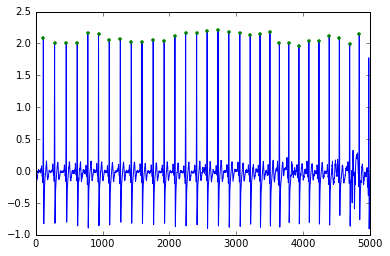

In [44]:
plt.plot(sample1)
plt.plot(sample1[tp], '.')

In [45]:
(peaks==tp).sum()

0

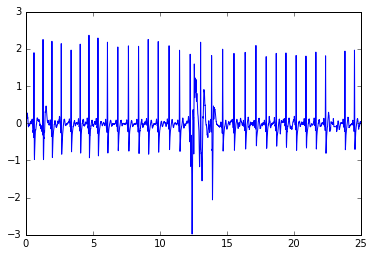

In [46]:
plot_peak_detection(sample2, 200)

In [47]:
sample2 = sample2.reset_index().ECG

In [48]:
peaks = detect_beats(sample2, 200)

In [49]:
peaks

array([ 118,  252,  386,  525,  673,  808,  938, 1073, 1214, 1370, 1528,
       1680, 1823, 1973, 2135, 2292, 2471, 2606, 2774, 2935, 3104, 3272,
       3432, 3585, 3735, 3881, 4033, 4180, 4328, 4472, 4761, 4904])

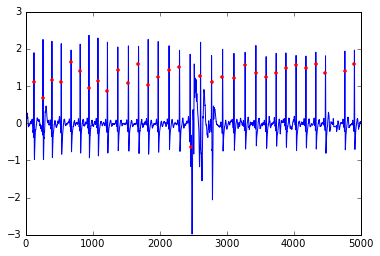

In [50]:
plt.plot(sample2)
plt.plot(sample2[peaks], 'r.')

In [51]:
peaks/200.

array([  0.59 ,   1.26 ,   1.93 ,   2.625,   3.365,   4.04 ,   4.69 ,
         5.365,   6.07 ,   6.85 ,   7.64 ,   8.4  ,   9.115,   9.865,
        10.675,  11.46 ,  12.355,  13.03 ,  13.87 ,  14.675,  15.52 ,
        16.36 ,  17.16 ,  17.925,  18.675,  19.405,  20.165,  20.9  ,
        21.64 ,  22.36 ,  23.805,  24.52 ])

In [52]:
tp = true_peaks(sample2, peaks)
tp

array([ 120,  255,  388,  527,  674,  810,  941, 1075, 1217, 1372, 1530,
       1681, 1825, 1975, 2137, 2293, 2467, 2608, 2772, 2937, 3106, 3273,
       3434, 3587, 3737, 3882, 4034, 4181, 4329, 4474, 4763, 4905])

In [53]:
(peaks==tp).sum()

0

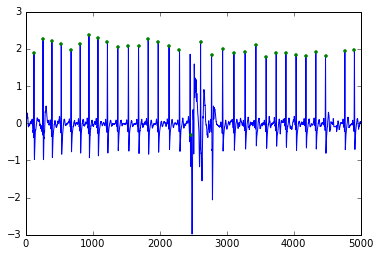

In [54]:
plt.plot(sample2)
plt.plot(sample2[tp], '.')

In [55]:
init_peaks = detect_beats(signal, 200)

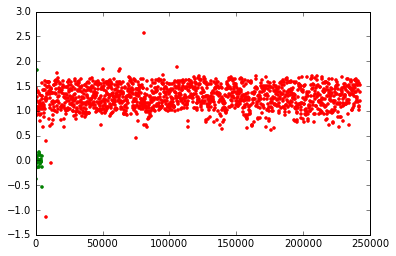

In [56]:
plt.plot(signal[init_peaks], "r.")
plt.plot(signal[tp], "g.")

In [57]:
tp = true_peaks(signal, init_peaks)

### using acq files

In [2]:
fl = "/Users/user/Desktop/csv of acq files/Subjects 1-15/20161107_1458_xpr-001-005_sbj001.txt"

In [3]:
data = pd.read_csv(fl, sep='\t', skiprows=11)

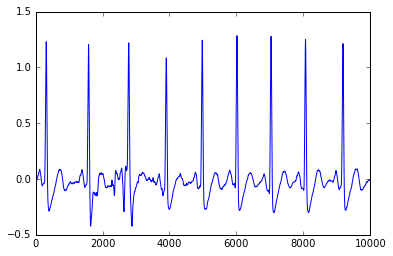

In [4]:
plt.plot(data.CH13[1:10000])

In [32]:
signal = data.CH13[1:].astype(float)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5217834 entries, 0 to 5217833
Data columns (total 5 columns):
CH1           float64
CH2           float64
CH13          float64
CH14          float64
Unnamed: 4    float64
dtypes: float64(5)
memory usage: 238.9 MB


In [7]:
#%%timeit
#rpeakdetect.detect_beats(signal, 2000)
#1 loops, best of 3: 6.22 s per loop

In [34]:
init_peaks = rpeakdetect.detect_beats(signal, 2000)

In [35]:
init_peaks

array([    268,    1581,    2785, ..., 5214512, 5215809, 5217175])

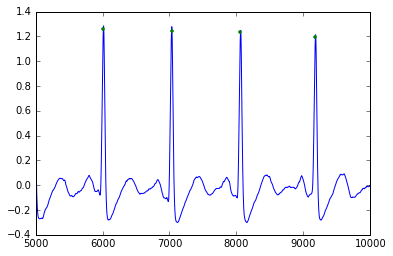

In [9]:
plt.plot(signal[5000:10000])
plt.plot(signal[5000:10000][init_peaks], '.')

In [31]:
signal[5000:10000][init_peaks]#==signal[5000:10000][tp*]

268            NaN
1581           NaN
2785           NaN
3902           NaN
4976           NaN
6012       1.26099
7030       1.24512
8060       1.23154
9179       1.19736
10382          NaN
11621          NaN
13017          NaN
14444          NaN
15900          NaN
17282          NaN
18670          NaN
19876          NaN
20981          NaN
22059          NaN
23132          NaN
24406          NaN
25972          NaN
27558          NaN
28852          NaN
29980          NaN
31096          NaN
32301          NaN
33773          NaN
35290          NaN
36708          NaN
            ...   
5182598        NaN
5183637        NaN
5184664        NaN
5185702        NaN
5186696        NaN
5187675        NaN
5188719        NaN
5189927        NaN
5191229        NaN
5192502        NaN
5193642        NaN
5194954        NaN
5196294        NaN
5197424        NaN
5198508        NaN
5199764        NaN
5201174        NaN
5202355        NaN
5203464        NaN
5204676        NaN
5206126        NaN
5207490     

In [36]:
%%timeit
rpeakdetectmod.detect_beats(signal, 2000)

1 loops, best of 3: 7.01 s per loop


In [37]:
tp = rpeakdetectmod.detect_beats(signal, 2000)

In [38]:
len(init_peaks)

4124

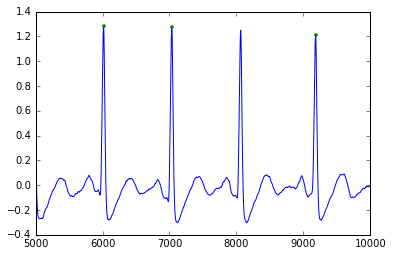

In [40]:
plt.plot(signal[5000:10000])
plt.plot(signal[5000:10000][tp*2000], '.')

In [14]:
signal[tp*2000 == init_peaks]

/Users/user/.virtualenvs/Data27/lib/python2.7/site-packages/pandas/core/internals.py:222: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5217833 but corresponding boolean dimension is 4124
  return self.values[slicer]
/Users/user/.virtualenvs/Data27/lib/python2.7/site-packages/pandas/core/index.py:1160: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5217833 but corresponding boolean dimension is 4124
  result = getitem(key)


60      0.017090
148     0.041962
171    -0.007782
409    -0.285492
751     0.078735
1006   -0.041504
1323    0.022125
1666   -0.337830
1747   -0.121613
1749   -0.123749
1753   -0.126648
1756   -0.128479
1759   -0.130920
1760   -0.131683
1762   -0.134277
1764   -0.136871
1766   -0.138397
1769   -0.141449
1775   -0.141449
1776   -0.139923
1784   -0.136261
1801   -0.135193
1808   -0.122375
1811   -0.119476
1836   -0.151520
1842   -0.142365
1885    0.018768
3183    0.052643
3348   -0.004272
3420   -0.005646
3669    0.020142
3682    0.033722
3742   -0.067139
3770   -0.087280
3777   -0.086822
3806   -0.146179
3863   -0.014496
3990   -0.270233
4051   -0.213318
4059   -0.200348
4060   -0.198669
4061   -0.196533
4091   -0.154724
Name: CH13, dtype: float64

In [15]:
(init_peaks == tp*2000).sum()*1.0/(len(init_peaks))

0.010426770126091174

In [ ]:
0.010426770126091174

In [28]:
a = np.array([1,0,1,2,1.5,3,0,1,2])

In [29]:
np.argmax(a[5-2:5+2])

2

In [27]:
np.argmax(a)

5

#### detect beats function

In [ ]:
def detect_beats(
		ecg,	# The raw ECG signal
		rate,	# Sampling rate in HZ
		# Window size in seconds to use for 
		ransac_window_size=5.0,
		# Low frequency of the band pass filter
		lowfreq=5.0,
		# High frequency of the band pass filter
		highfreq=15.0,
		):
	"""
	ECG heart beat detection based on
	http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
	with some tweaks (mainly robust estimation of the rectified signal
	cutoff threshold).
	"""

	ransac_window_size = int(ransac_window_size*rate)

	lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
	highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
	# TODO: Could use an actual bandpass filter
	ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
	ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
	
	# Square (=signal power) of the first difference of the signal
	decg = np.diff(ecg_band)
	decg_power = decg**2
	
	# Robust threshold and normalizator estimation
	thresholds = []
	max_powers = []
	for i in range(len(decg_power)/ransac_window_size):
		sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
		d = decg_power[sample]
		thresholds.append(0.5*np.std(d))
		max_powers.append(np.max(d))

	threshold = 0.5*np.std(decg_power)
	threshold = np.median(thresholds)
	max_power = np.median(max_powers)
	decg_power[decg_power < threshold] = 0

	decg_power /= max_power
	decg_power[decg_power > 1.0] = 1.0
	square_decg_power = decg_power**2

	shannon_energy = -square_decg_power*np.log(square_decg_power)
	shannon_energy[~np.isfinite(shannon_energy)] = 0.0

	mean_window_len = int(rate*0.125+1)
	lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
	#lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
	
	lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
	lp_energy_diff = np.diff(lp_energy)

	zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
	zero_crossings = np.flatnonzero(zero_crossings)
	zero_crossings -= 1
	return zero_crossings